# Pairwise

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
from models.aux import mySentenceTransformer
from models.pairwise import TargetEncoder, ContextEncoderConcat, ChainCosine
context_size = 3
encoder_name = 'aws-ai/dse-bert-large'

_encoder = mySentenceTransformer(encoder_name)
_target_encoder = TargetEncoder(_encoder)
_context_encoder = ContextEncoderConcat(_encoder, context_size=context_size)
_model = ChainCosine(
    target_encoder=_target_encoder,
    context_encoder=_context_encoder,
    projection_size=256,
    context_size=context_size,
)

model = ChainCosine.from_checkpoint(
    path_to_ckpt='/home/alekseev_ilya/dialogue-augmentation/nup/logs/training/pairwise-cat-speaker-issue/checkpoints/last.ckpt',
    model=_model,
    map_location='cuda'
).eval()

del _encoder
del _target_encoder
del _context_encoder
del _model

In [5]:
import torch.nn.functional as F
import torch

@torch.no_grad()
def get_score(logits, absolute=False, reduction='none'):
    if absolute:
        scores = logits.diag()
    else:
        scores = F.softmax(logits, dim=1).diag().log10()
    if reduction == 'mean':
        score = scores.mean()
    elif reduction == 'min':
        score = scores.min()
    elif reduction == 'max':
        score = scores.max()
    elif reduction != 'none':
        raise ValueError('unexpected reduction type')
    else:
        return scores.cpu().numpy()
    return score.cpu().item()

## Score vs Shuffling

In [6]:
import json

n_dialogues = 128
dataset = json.load(open('/home/alekseev_ilya/dialogue-augmentation/nup/dialogues/val/0.json', 'r'))[:n_dialogues]

скор имеет следующий смысл: среднее правдоподобие переходов в диалоге

In [7]:
import numpy as np
import math
from tqdm.autonotebook import tqdm
from collections import defaultdict


def random_swap(arr, n_swaps):
    """n_swaps must be bounded by len(arr) / 2"""
    arr = arr[:]
    idx_pairs = np.random.choice(len(arr), (n_swaps, 2), replace=False)
    for i, j in idx_pairs:
        arr[i], arr[j] = arr[j], arr[i]
    return arr

grid_size = 11
fraction_swaps_list = np.linspace(0, 1, grid_size)
temperature_list = np.linspace(0.05, 0.5, 10).tolist() + [1]
exp_results = defaultdict(list)

for i, dia in enumerate(tqdm(dataset)):
    for frac in fraction_swaps_list:
        n_swaps = math.ceil(frac * (len(dia) // 2))
        dia = random_swap(dia, n_swaps)
        with torch.no_grad():
            batch = model.make_batch_from_dia(dia)
            logits = model.get_logits(batch, temperature=1)
            for t in temperature_list:
                exp_results['frac'].append(frac)
                exp_results['t'].append(t)
                exp_results['i_dia'].append(i)
                exp_results['rel_score_mean'].append(get_score(logits / t, reduction='mean'))
                exp_results['rel_score_min'].append(get_score(logits / t, reduction='min'))
                exp_results['rel_score_max'].append(get_score(logits / t, reduction='max'))
                exp_results['abs_score_mean'].append(get_score(logits / t, absolute=True, reduction='mean'))
                exp_results['abs_score_min'].append(get_score(logits / t, absolute=True, reduction='min'))
                exp_results['abs_score_max'].append(get_score(logits / t, absolute=True, reduction='max'))

100%|██████████| 128/128 [03:57<00:00,  1.86s/it]


In [8]:
import pandas as pd


df = pd.DataFrame(exp_results)

<Axes: xlabel='frac', ylabel='abs_score_mean'>

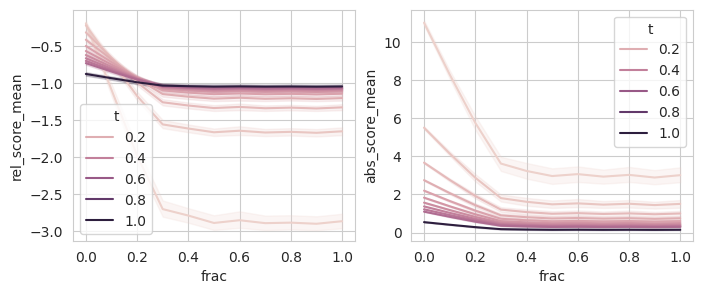

In [9]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.lineplot(data=df, x='frac', y='rel_score_mean', hue='t', ax=ax[0])
sns.lineplot(data=df, x='frac', y='abs_score_mean', hue='t', ax=ax[1])

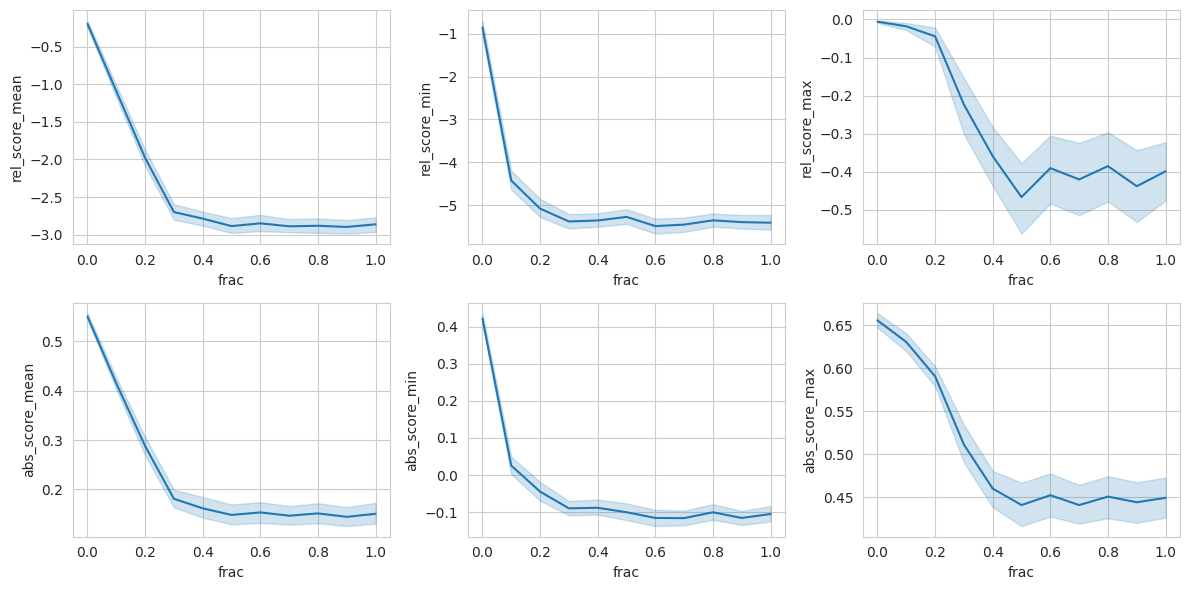

In [10]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 3, figsize=(12, 6))

df_t = df[df.t == 0.05]
sns.lineplot(data=df_t, x='frac', y='rel_score_mean', ax=ax[0, 0])
sns.lineplot(data=df_t, x='frac', y='rel_score_min',  ax=ax[0, 1])
sns.lineplot(data=df_t, x='frac', y='rel_score_max',  ax=ax[0, 2])

df_t = df[df.t == 1]
sns.lineplot(data=df_t, x='frac', y='abs_score_mean', ax=ax[1, 0])
sns.lineplot(data=df_t, x='frac', y='abs_score_min',  ax=ax[1, 1])
sns.lineplot(data=df_t, x='frac', y='abs_score_max',  ax=ax[1, 2])
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


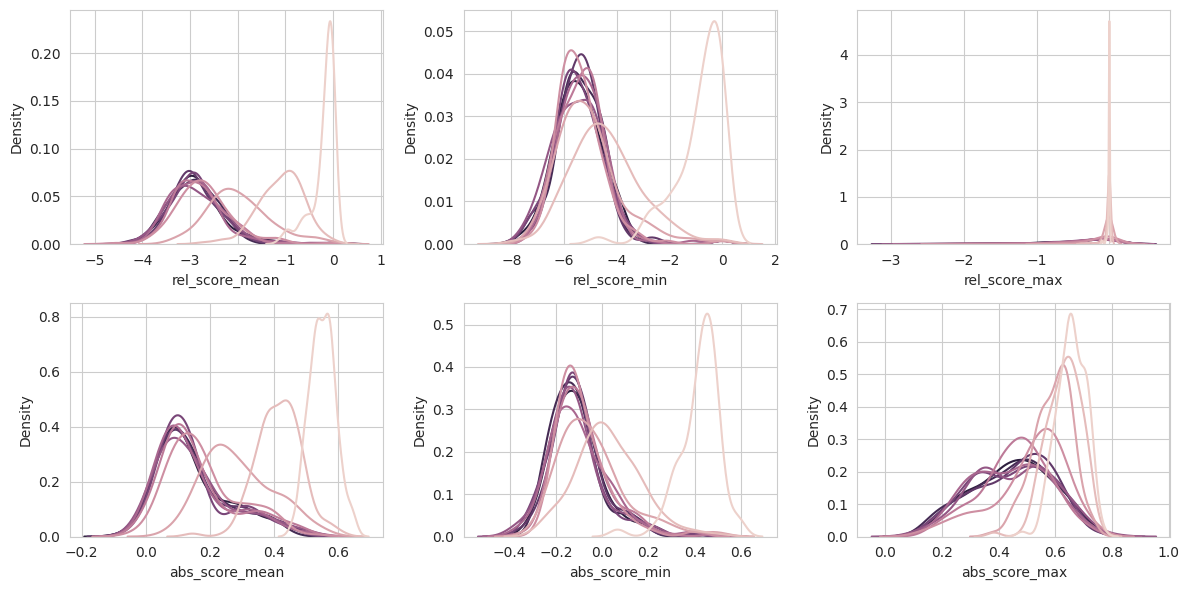

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

df_t = df[df.t == .05]
sns.kdeplot(data=df_t, hue='frac', x='rel_score_mean', ax=ax[0, 0])
sns.kdeplot(data=df_t, hue='frac', x='rel_score_min',  ax=ax[0, 1])
sns.kdeplot(data=df_t, hue='frac', x='rel_score_max',  ax=ax[0, 2])

df_t = df[df.t == 1]
sns.kdeplot(data=df_t, hue='frac', x='abs_score_mean', ax=ax[1, 0])
sns.kdeplot(data=df_t, hue='frac', x='abs_score_min',  ax=ax[1, 1])
sns.kdeplot(data=df_t, hue='frac', x='abs_score_max',  ax=ax[1, 2])

for a in ax.flatten():
    a.legend(frameon=False)
plt.tight_layout()

## Score vs Position

In [12]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [13]:
from collections import defaultdict
from tqdm.autonotebook import tqdm

t = 0.1
exp_results = defaultdict(list)

with torch.no_grad():
    for i_dia, dia in enumerate(tqdm(dataset)):
        batch = model.make_batch_from_dia(dia)
        logits = model.get_logits(batch, temperature=1)
        abs_scores = get_score(logits, absolute=True)
        rel_scores = get_score(logits / t)
        for i_pair, (abs_score, rel_score) in enumerate(zip(abs_scores, rel_scores)):
            exp_results['i_dia'].append(i_dia)
            exp_results['i_pair'].append(i_pair)
            exp_results['abs_score'].append(abs_score)
            exp_results['rel_score'].append(rel_score)

100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


In [14]:
import pandas as pd


df = pd.DataFrame(exp_results)

In [15]:
def show_positionwise_scores(i_dia):
    speaker_alias = "AB"
    dia = dataset[i_dia]
    abs_scores = [1] + df[df.i_dia == i_dia].sort_values('i_pair')['abs_score'].tolist()
    uts = [f'[{speaker_alias[item["speaker"]]}] [score: {abs_score:5.2f}] {item["utterance"]}' for abs_score, item in zip(abs_scores, dia)]
    print('\n'.join(uts))

[A] [score:  1.00] My husband and I are celebrating our anniversary and want to find a great place to stay in town.
[B] [score:  0.59] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
[A] [score:  0.72] I would like a 4 star guesthouse that includes free parking.
[B] [score:  0.64] I have several options for you, is there a particular area you are interested in during your stay?
[A] [score:  0.68] yes should be in the west
[B] [score:  0.66] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book for you?
[A] [score:  0.66] Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course!
[B] [score:  0.67] Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number FKRO2HOW . Will there be anything else?
[A] [score:  0.52] I am wanting to know more about the Cambridge Museum of Technology.
[B] [score:  0.62] Sure, it's located in the ce

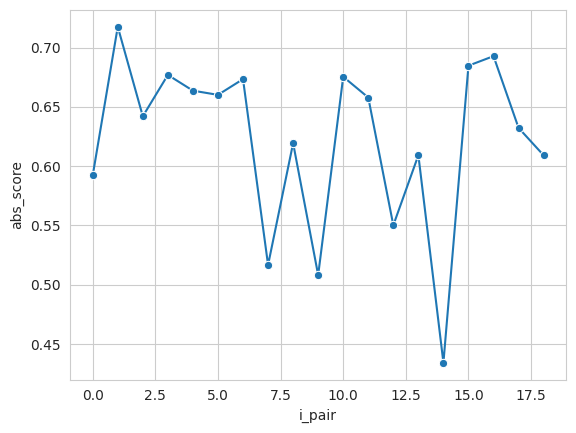

In [16]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

i_dia = 1
show_positionwise_scores(i_dia)
# sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='rel_score', marker='o')
sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='abs_score', marker='o')
plt.show()

- для аугментации катом есть смысл сплиттить уттерансы состоящие из нескольких предложений потому что иногда они содержат несколько интентов
- вручную сегментировать эти 15 диалогов

### Manual Segmenting Dialogues

In [17]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

def show_dia(i_dia):
    dia = dataset[i_dia]
    speaker_alias = "AB"
    uts = [f'[{speaker_alias[item["speaker"]]}] {item["utterance"]}' for item in dia]
    print('\n'.join(uts))
    print(len(uts))

segments = []
segments_precise = []

In [18]:
show_dia(0)

[A] I'm looking for a local place to dine in the centre that serves chinese food.
[B] I have restaurants matching your criteria in all price ranges. Do you have a preference on price?
[A] I need the address, postcode and the price range.
[B] Ok how about Charlie Chan, located at Regent Street City Centre. Postcode is cb21db with a cheap price. Can I help you further today?
[A] I also need a train. The train should leave after 16:15 and should leave on sunday.
[B] Can I have more information for the train you're needing? Where are you departing from and arriving to?
[A] I am leaving from Cambridge and going to Norwich.
[B] I have train TR1840 leaving at 16:36 is that okay?
[A] book for 5 people and get me the reference number
[B] You're all set. Reference number is NJB87PAP . Is there anything else I can help you with today?
[A] No, this is all I will need. Thank you.
[B] Thank for calling us today. I hope you have a good trip.
12


In [19]:
segments.append([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2])
segments_precise.append([0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5])

In [20]:
show_dia(1)

[A] My husband and I are celebrating our anniversary and want to find a great place to stay in town.
[B] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
[A] I would like a 4 star guesthouse that includes free parking.
[B] I have several options for you, is there a particular area you are interested in during your stay?
[A] yes should be in the west
[B] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book for you?
[A] Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course!
[B] Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number FKRO2HOW . Will there be anything else?
[A] I am wanting to know more about the Cambridge Museum of Technology.
[B] Sure, it's located in the centre area of town. The phone number is 01223368650. The entrance fee is 5 pounds.
[A] What is the address, please.
[B] The address is the old pumping 

In [21]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, [1, 2], 1, 2, 2, 2, 2, 3, 3])
segments_precise.append([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7])

In [22]:
show_dia(2)

[A] I need a taxi to come to backstreet bistro by 19:30.
[B] Where would you be coming from?
[A] I'm coming from sesame restaurant and bar.
[B] I can book you a Grey BMW with the contact number 07216877402. Is there anything else I can do for you today?
[A] Nope, that is everything! Thanks!
[B] Thank you for contacting us and have a great day.
6


In [23]:
segments.append([0, 0, 0, 0, 1, 1])
segments_precise.append([0,1,1, 2, 3, 3])

In [24]:
show_dia(3)

[A] I'm looking for a place to go in the west of town.
[B] Do you have a specific place in mind that you will like to visit?
[A] A college I think would be best.
[B] There are five colleges in that area that you can visit. Three of them are free to visit and two have a small entrance fee. What is your preference as far as that goes?
[A] can i get the college's phone number. i am also looking for a train to birmingham new street and should depart from cambridge looking for a train
[B] The phone for Churchill College is 01223336233. As far as the train goes, what day and time would you like to travel?
[A] I would like to leave on Sunday and arrive by 17:15.
[B] Okay, I have a train leaving at 14:01 and arriving by 16:44. Would you like me to book it for you?
[A] No, but could you please show me the specific travel time?
[B] The travel duration is 163 minutes, is there anything else I can do for you?
[A] No, that is all. Thank you! Goodbye!
[B] Okay. Thank you for choosing help desk.
12


In [25]:
segments.append([0, 0, 0, 0, [0, 1], [0, 1], 1, 1, 1, 1, 2, 2])
segments_precise.append([0,1,1,2,[2,3],[3,4],4,4,5,5,6,6])

In [26]:
show_dia(4)

[A] I'm looking for an expensive restaurant in the centre.
[B] I can recommend several restaurants in the centre of town. Are you looking for any type of food in particular
[A] Yes, Caribbean food please.
[B] There is no matching restaurant. Would you like to change your search criteria?
[A] What about a restaurant that serves european food?
[B] I found 2 expensive european restaurants and 1 expensive modern european restaurant. Which kind would you prefer?
[A] I don't have a preference.
[B] Okay, I can book your table at Eraina. They serve european food. How many in your party, what day and time please?
[A] I would like to book for Tuesday at 12:45.
[B] Are you looking to book for just yourself?
[A] Yes. Just one person.
[B] Great your reference number is 2K1P6FTA . Thank you.
[A] I also need to find a train from stansted airport to cambridge that arrives by 8:00 on tuesday.
[B] Alright, there are three different trains leaving that morning that will get you there on time. Each one ha

In [27]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
segments_precise.append([0,0,0,1,1,1,1,2,2,3,3,4,5,5,[5,6],[5,6],7,8,9,10])

In [28]:
show_dia(5)

[A] I want general information on places to go in the centre area of town.
[B] There are many attractions available, including architecture, theatre, swimming pools, parks, night clubs, museums, and cinemas. What are you most interested in?
[A] It doesn't really matter, maybe a museum? I'll need the entrance fee also please.
[B] i would recommend primavera located in 10 king s parade, cb21sj. phone number is 01223357708.
[A] Okay. Can you find me a train to Broxbourne. I need to arrive by 21:00.
[B] Where will you be departing from?
[A] I'm leaving from Cambridge
[B] The first train leaves at 5:01.
[A] Ok, I need to book the train for 6 people please.
[B] Booking was successful, the total fee is 107.4 GBP payable at the station . Reference number is : AEE0QDGA . Is there anything else I can help with?
[A] No. You took care of everything. Thanks. Goodbye.
[B] Okay fantastic, have a great day.
12


In [29]:
segments.append([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2])
segments_precise.append([0,0,0,0,1,1,1,2,3,3,4,4])

In [30]:
show_dia(6)

[A] i want information about a place i can see local attractions.
[B] Okay! What part of town would you like to visit?
[A] Come to think of it, let's put that off for now. I was thinking of trying some new cuisine while we are in town. Something expensive.
[B] Okay! What cuisine would you like to try?
[A] I've got a couple of Jamaican buddies and I want to make them feel at home.
[B] We don't have any expensive Jamaican places in town. Do you want to try something else?
[A] How about something that serves African food?
[B] The Bedouin in the city centre is an expensive African restaurant. Would you like me to book it for you?
[A] I don't need a table right now, but I do need the postcode and phone number for that restaurant.
[B] the phone number is 01223367660 and the postcode is cb12bd
[A] Thanks for that info. I also need attractions in the same section of town as the restaurant. Do you have any boat activities?
[B] There are 2 in that area. They are Scudamores Punting Co and The Cam

In [31]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2])
segments_precise.append([0,0,1,1,1,1,2,2,3,3,4,4,4,4,5,5])

In [32]:
show_dia(7)

[A] I'm looking to play a variety of sports. Are there facilities that cater to that?
[B] Yes, there is one such facility, The Cherry Hinton Village Centre, located at colville road, cherry hinton in the east side of town.
[A] Do you have anything like that in the centre?
[B] Unfortunately, we do not.
[A] What about a museum in the center?
[B] I have listings for 5, can i recommend one?
[A] Yes please, and I'm going to need the address.
[B] You may want to try castle galleries.
[A] What is their address?
[B] The Castle Galleries is located at Unit SU43, Grande Arcade, Saint Andrews Street. It's in the City Centre.
[A] Okay, that sounds great. I also need a train that leaves on Sunday after 17:30 from Cambridge going to Stevenage.
[B] I have train TR8726 that would leave at 19:21 and get you to Stevenage at 20:10. Would that work for you?
[A] Yeah, can you book 4 tickets for me?
[B] Booking was successful, the total fee is 40.96 GBP payable at the station . Reference number is : MVFN99U

In [33]:
segments.append([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3])
segments_precise.append([0,0,1,1,2,2,2,2,3,3,4,4,4,4,5,5])

In [34]:
show_dia(8)

[A] Are there any accommodations in the east part of town that off free parking?
[B] I have 6 places. Would you prefer a guesthouse or a hotel?
[A] I want it to be a hotel and also include free wifi.
[B] I have the express by holiday inn cambridge. Would you like me to book it for you?
[A] What is their star rating?
[B] it has a two star rating
[A] Can you also tell me the address?
[B] It is located at 15-17 norman way, coldhams business park.
[A] I need a train, as well. It should leave on tuesday and go to london liverpool street.
[B] great, what is your departure site?
[A] My departure site is Cambridge please.
[B] And what time will you be needing to leave after or arrive by?
[A] I will need to leave after 15:45
[B] TR4276 leaves at 15:59, will this option work for you?
[A] Yes that train will work for me.
[B] for how many people do i book?
[A] Just one person please and I need a reference number
[B] I have booked one seat on TR4276. Your reference number is FKIX0BCE . Can I be of 

In [35]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5])
segments_precise.append([0,0,0,1,2,2,3,3,4,5,5,6,6,7,7,8,8,8,9,10,11,11,11,11,12,12,13,13])

In [36]:
show_dia(9)

[A] I need to book a train for Monday going to Cambridge please.
[B] There are quite a few trains that could suit your needs. Can you tell me where you would like to depart from?
[A] I'll be at London's Kings Cross and wanting to leave after 11:45 am.
[B] There is a train that leaves London Kings Cross at 13:17 and arrives in Cambridge at 14:08. Does that time work for you?
[A] Yes, that sounds fine. Can you book me tickets for 8 people, please?
[B] Your booking was successful. The total fee is 188.8 GBP payable at the station. The reference number is 2EGCVFWC
[A] Thank you goodbye
[B] Thank you and goodbye.
[A] Before you go, could you help me find an expensive restaurant in the city centre?
[B] Do you have a preference for the type of food?
[A] Yes, I'd like some classic British cuisine.
[B] Midsummer House Restaurant serves British food. Would you like me to book you a table?
[A] Yes, that place sounds perfect. If I could book for 8 on the same day at 15:00 it would be great.
[B] Bo

In [37]:
segments.append([0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3])
segments_precise.append([0,1,1,2,2,2,3,3,4,5,5,6,6,7,8,8])

In [38]:
show_dia(10)

[A] I need a train going to bishops stortford.
[B] Ok. and where are you departing from?
[A] I'll be departing from Cambridge.
[B] And what day will you be traveling on?
[A] I would like to travel on Sunday.
[B] Is there a certain time you would like to leave after or arrive by?
[A] I can't leave until after 20:30.
[B] TR1389 leaves at 21:29
[A] Can you arrange travel for 7 people for TR1389 on Sunday?
[B] Of course. The reference number is NI1LNIIP . The total fee is 56.56 which can be paid at the station.
[A] Great, thank you. I am also looking for a modern European restaurant.
[B] I have 5 options for you. Do you have a price range in mind?
[A] Yes. It should be in the moderate price range.
[B] The three choices are Restaurant Alimentum, De Luca Cucina, and Riverside Brasserie. Do you require me to book the table?
[A] The Riverside Brasserie sounds good. Can you tell me the area they are located in?
[B] Riverside Brasserie is located in the centre. Can I help you with anything else 

In [39]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3])
segments_precise.append([0,1,1,2,2,3,3,3,4,4,5,5,5,6,[6,7],7,8,8,8,8,11,11,12,13,13,14])

In [40]:
show_dia(11)

[A] I'd like to find a train from Leiceter on Saturday.
[B] Where will you be heading?
[A] I am going to cambridge and need to leave after 12:00
[B] The TR7248 leaves at 12:09, would you like a ticket on that train?
[A] I don't need to book just yet. But can I get the arrival time and price per ticket.
[B] Yes the train arrives in Cambridge at 13:54 and the total cost of the journey is 30.24 pounds.
[A] Okay great. That is all I needed to know.
[B] Glad to help. Contact me again if you would like a booking. Have a nice day. Bye.
8


In [41]:
segments.append([0, 0, 0, 0, 0, 0, 1, 1])
segments_precise.append([0,1,1,2,[2,3],3,4,4])

In [42]:
show_dia(12)

[A] I'm looking for a nice place to stay, somewhere expensive and luxurious with all the amenities like free wifi. Can you recommend something like that?
[B] i have at least five options for you. do you need free parking too?
[A] I don't need it, but either way. As long as the hotel is expensive and has free wifi I don't mind. Are any located in the centre?
[B] Yes, I recommend the University Arms Hotel. Would you like ma to make a reservation for you?
[A] No may I just have the postcode and star rating of the hotel.
[B] Sure, their postcode is cb21ad and it's rated 4 stars.
[A] Also, i need a train on Tuesday around 09:45.
[B] Where are you heading to and departing from please?
[A] I am leaving from Ely heading to Cambridge.
[B] I have train TR3412 leaving at 11:35 and arriving at 11:52.
[A] That sounds great. Can you please book it for four people?
[B] Booking was successful, the total fee is 17.6 GBP payable at the station . Reference number is : 6VFKQ7J6 .
[A] Thank you for your he

In [43]:
segments.append([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])
segments_precise.append([0,1,[1,2],[2,3],4,4,5,6,6,7,8,9,10,10,11,12,12,12])

In [44]:
show_dia(13)

[A] I'm looking for a train leaving on Wednesday that's going to Cambridge.
[B] Okay, where are you departing?
[A] I'm leaving from ely to cambridge.
[B] Sure I can help with that, the first train leaves ely at 05:35 and the last one runs at 13:35, do you have a particular time in mind?
[A] The last train sounds like it will work best. Can you book me 4 tickets for that one please?
[B] Booked! You'll play 17.6 GBP at the station. Reference number: OJUFDKX1 .
[A] Great I also need some information about the Ruskin Gallery attraction.
[B] Certainly. The Ruskin Gallery is a museum in the centre of town. It's free to enter. Would you like more information?
[A] phone number, and address please
[B] Their address is Anglia Ruskin University, East Road. And their phone number is 01245493131. Need anything else?
[A] Nope, that's all I need today. Thank you for all your help.
[B] You're very welcome. Have a great time!
12


In [45]:
segments.append([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2])
segments_precise.append([0,1,1,2,3,3,4,4,5,5,6,6])

In [46]:
show_dia(14)

[A] I need a train from birmingham new street to cambridge, please.
[B] There are 133 trains traveling that path. What day would you like to travel on?
[A] I would like to leave on Wednesday sometime after 11:30.
[B] How about the TR1670? It meets your specifications and leaves at 11:40.
[A] How long is the train ride?
[B] The train ride is 163 minutes, does this suit your needs?
[A] How much is the fare on that train?
[B] It is 75.10 pounds.
[A] What is the exact arrival time? I'm also looking for a place to dine in the centre of town. I'm looking for an expensive modern european restaurant.
[B] Let's take care of the train first. The train will arrive by 14:23 in Cambridge. Would you like to book a ticket?
[A] Thank you I do not need to book the train, but I am looking for an expensive restaurant in the centre of town.
[B] We have many expensive places in the center of town! Is there a particular type of cuisine you'd like to try?
[A] I would like modern European food.
[B] How about 

In [47]:
segments.append([0, 0, 0, 0, 0, 0, 0, 0, [0, 1], 0, [0, 1], 1, 1, 1, 1, 1, 2, 2])
segments_precise.append([0,1,1,2,3,3,4,4,[5,6],5,[5,6],6,6,7,8,8,9,9])

### Checking Hypothesis

Из 15 диалогов можно получить положительные и отрицательные пары последовательных уттерансов в которых сменилась или не сменилась тема. С помощью модели для этих пар можно получить скор. По итогу выяснить, насколько хорошо по этому скору разделяются положительные и отрицательные пары

In [48]:
def is_switch(lab1, lab2):
    a = lab1 != lab2
    b = isinstance(lab1, list) or isinstance(lab2, list)
    return a or b
abs_scores_list = []
rel_scores_list = []
i_pair_list = []
is_switch_list = []
is_switch_precise_list = []
i_dia_list = []
for i_dia in range(15):
    df_tmp = df[df.i_dia == i_dia].sort_values('i_pair')
    abs_scores = df_tmp['abs_score'].tolist()
    rel_scores = df_tmp['rel_score'].tolist()
    abs_scores_list.extend(abs_scores)
    rel_scores_list.extend(rel_scores)
    # print(len(scores), len(segments))
    for i in range(len(abs_scores)):
        is_switch_list.append(is_switch(segments[i_dia][i], segments[i_dia][i+1]))
        is_switch_precise_list.append(is_switch(segments_precise[i_dia][i], segments_precise[i_dia][i+1]))
    i_pair_list.extend(list(range(len(abs_scores))))
    i_dia_list.extend([i_dia] * len(abs_scores))
    

df_switch = pd.DataFrame({
    'abs_score': abs_scores_list,
    'rel_score': rel_scores_list,
    'i_pair': i_pair_list,
    'i_dia': i_dia_list,
    'is_switch': is_switch_list,
    'is_switch_precise': is_switch_precise_list
})

In [49]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score


def draw_switch(df, absolute=False):
    if absolute:
        x = 'abs_score'
    else:
        x = 'rel_score'
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    sns.kdeplot(df, x=x, hue='is_switch', ax=ax[0,1])
    sns.scatterplot(df, x=x, y='is_switch', hue='is_switch', ax=ax[0,0])
    sns.kdeplot(df, x=x, hue='is_switch_precise', ax=ax[1,1])
    sns.scatterplot(df, x=x, y='is_switch_precise', hue='is_switch_precise', ax=ax[1,0])
    ax[0,0].get_legend().remove()
    ax[1,0].get_legend().remove()
    clf_score = average_precision_score(df['is_switch'], -df[x])
    clf_score_precise = average_precision_score(df['is_switch_precise'], -df[x])
    print('is_switch clf metric:', clf_score)
    print('is_switch_precise clf metric:', clf_score_precise)
    plt.tight_layout()
    plt.show()

если смотреть так, то свитчи и несвитчи очень плохо разделяются по скору:

is_switch clf metric: 0.40360141000276334
is_switch_precise clf metric: 0.5718280665122057


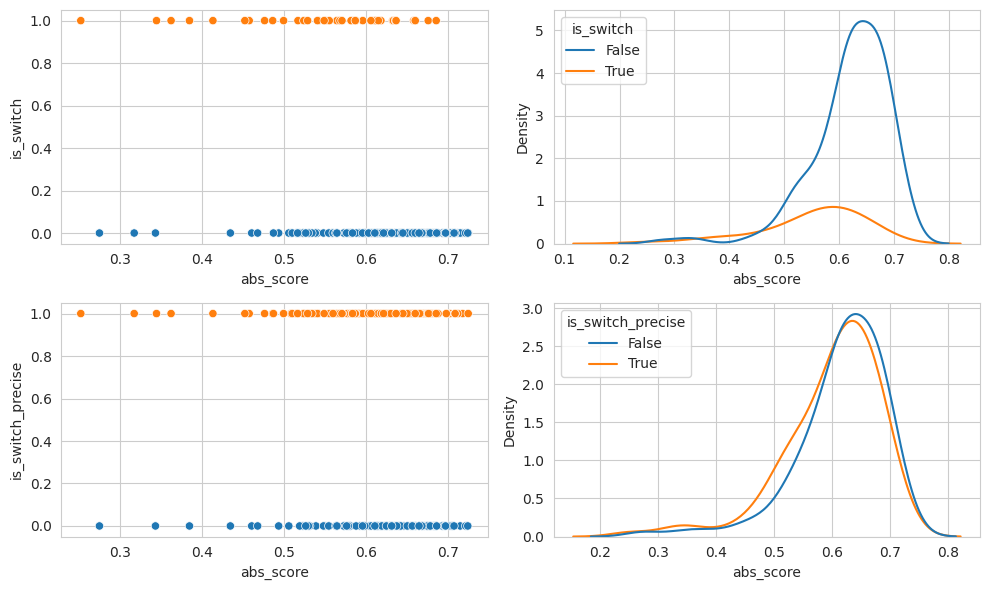

In [50]:
draw_switch(df_switch, absolute=True)

и использование относительных скоров вместо абсолютных не помогает:

is_switch clf metric: 0.4040225060703218
is_switch_precise clf metric: 0.6076174070156383


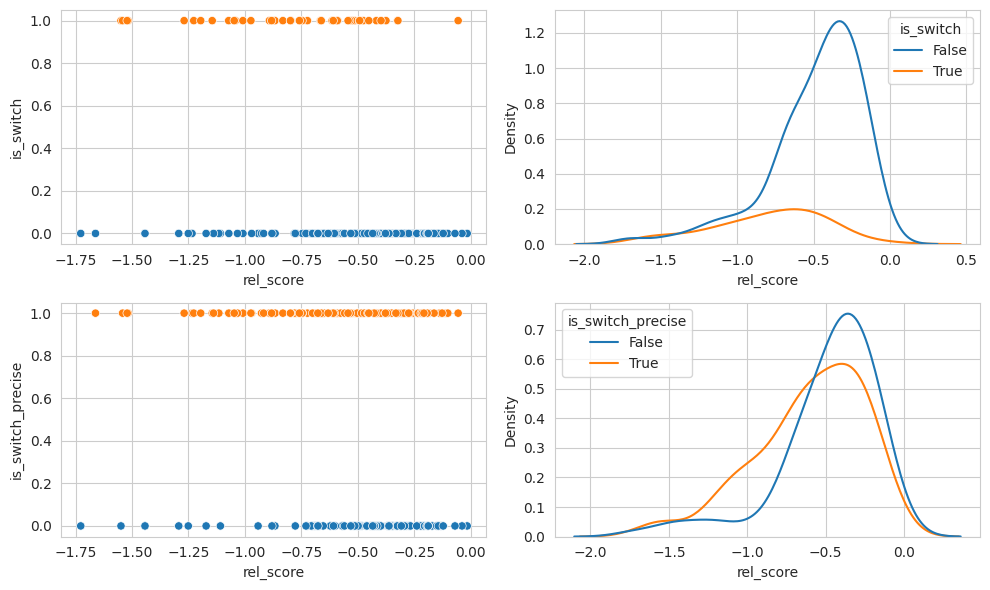

In [51]:
draw_switch(df_switch, absolute=False)

но если смотреть на отдельные диалоги, то видно что свитчи и несвитчи разделимы (с некоторой точностью)
- `is_switch`: 0, 8, 9, 11, 12, 14
- `is_switch_precise`: 0, 8, 13

is_switch clf metric: 0.7833333333333332
is_switch_precise clf metric: 0.8975996225996226


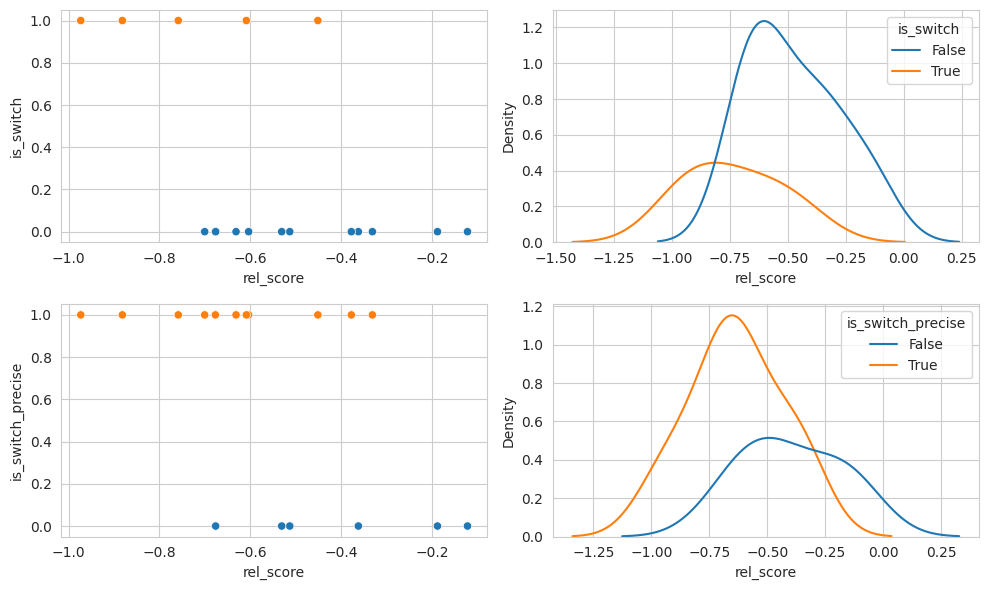

In [52]:
i_dia = 14
draw_switch(df_switch[df_switch.i_dia == i_dia])

is_switch clf metric: 0.7342424242424244
is_switch_precise clf metric: 0.6834037307721519


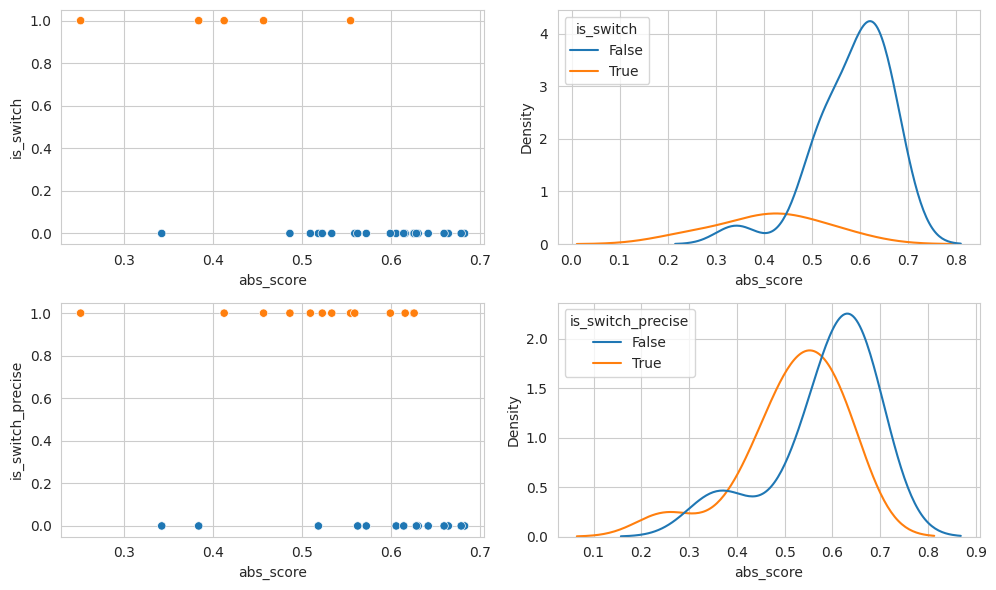

In [53]:
i_dia = 8
draw_switch(df_switch[df_switch.i_dia == i_dia], absolute=True)

In [54]:
def compute_clf_metrics(df, target_name, score_name):
    res = []
    for i_dia in range(15):
        df_ = df[df.i_dia == i_dia]
        res.append(average_precision_score(df_[target_name], -df_[score_name]))
    return res

In [55]:
abs_ = compute_clf_metrics(df_switch, 'is_switch', 'abs_score')
rel_ = compute_clf_metrics(df_switch, 'is_switch', 'rel_score')
abs_precise = compute_clf_metrics(df_switch, 'is_switch_precise', 'abs_score')
rel_precise = compute_clf_metrics(df_switch, 'is_switch_precise', 'rel_score')

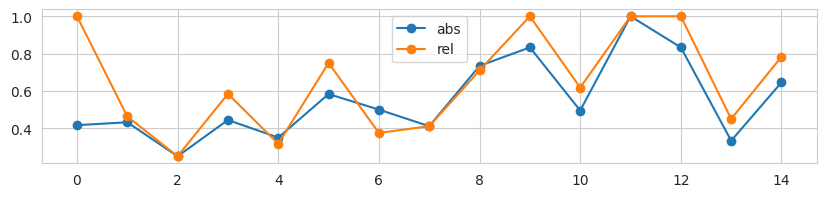

In [56]:
plt.figure(figsize=(10,2))
x = range(15)
plt.plot(abs_, label='abs', marker='o')
plt.plot(rel_, label='rel', marker='o')
plt.legend()

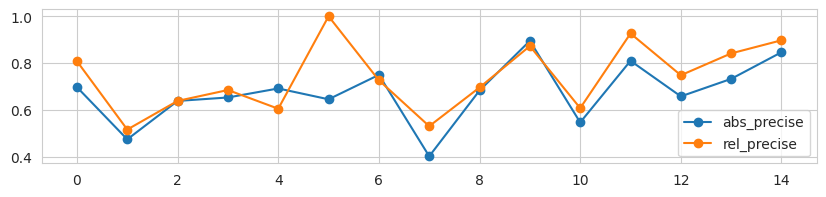

In [57]:
plt.figure(figsize=(10,2))
x = range(15)
plt.plot(abs_precise, label='abs_precise', marker='o')
plt.plot(rel_precise, label='rel_precise', marker='o')
plt.legend()

недостаток проведенного анализа: мало данных (всего 15 диалогов)

## Negative vs Positive Scores

In [58]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [59]:
from collections import defaultdict
from tqdm.autonotebook import tqdm
import torch
import torch.nn.functional as F

t = 1
scores_list = []
for i_dia, dia in enumerate(tqdm(dataset)):
    with torch.no_grad():
        batch = model.make_batch_from_dia(dia)
        logits = model.get_logits(batch, temperature=t)
        scores_list.append(F.softmax(logits, dim=1).cpu().numpy())

100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


[A] [score:  1.00] I need a train from birmingham new street to cambridge, please.
[B] [score:  0.64] There are 133 trains traveling that path. What day would you like to travel on?
[A] [score:  0.66] I would like to leave on Wednesday sometime after 11:30.
[B] [score:  0.67] How about the TR1670? It meets your specifications and leaves at 11:40.
[A] [score:  0.62] How long is the train ride?
[B] [score:  0.67] The train ride is 163 minutes, does this suit your needs?
[A] [score:  0.64] How much is the fare on that train?
[B] [score:  0.61] It is 75.10 pounds.
[A] [score:  0.64] What is the exact arrival time? I'm also looking for a place to dine in the centre of town. I'm looking for an expensive modern european restaurant.
[B] [score:  0.59] Let's take care of the train first. The train will arrive by 14:23 in Cambridge. Would you like to book a ticket?
[A] [score:  0.59] Thank you I do not need to book the train, but I am looking for an expensive restaurant in the centre of town.
[B

<Axes: >

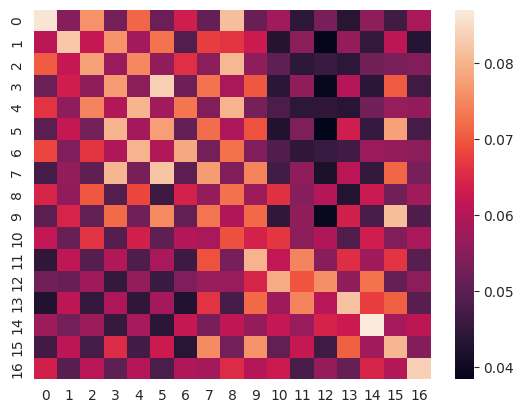

In [60]:
import seaborn as sns
sns.set_style('whitegrid')

i_dia=14
show_positionwise_scores(i_dia)
sns.heatmap(scores_list[i_dia], annot=False, fmt='.1f')

Практический итог:
- с помощью pairwise модели находим все intent switch и turn switch
- шаффлим тёрны внутри каждого интента
- шаффлим интенты

Недостатки проведённого анализа:
- мало данных

## Augmentation Development

### Naive

In [31]:
def show_switches(scores, dia, quantile=0.1):
    thresh = np.quantile(scores, quantile)
    i_switches = np.nonzero(scores < thresh)[0] + 1
    speaker_alias = "AB"
    scores = [0] + scores.tolist()
    uts = [f'[{speaker_alias[item["speaker"]]}] [score: {score:5.2f}] {item["utterance"]}' for score, item in zip(scores, dia)]
    for i in i_switches:
        uts[i] = '>' + uts[i]
    print('\n'.join(uts))

In [70]:
import json

dialogues = json.load(open('../aug-data/original.json', 'r'))

In [69]:
import numpy as np
from collections import defaultdict
import torch

i_dia = 8

t = 1
df_scores = defaultdict(list)
dia = dialogues[i_dia]
with torch.no_grad():
    batch = model.make_batch_from_dia(dia)
    logits = model.get_logits(batch, temperature=t)
    scores = get_score(logits)

NameError: name 'dialogues' is not defined

In [67]:
show_switches(scores, dia, 0.2)

NameError: name 'show_switches' is not defined

### Clustering

- `is_switch`: 0, 8, 9, 11, 12, 14
- `is_switch_precise`: 0, 8, 13

In [136]:
from sklearn.metrics import v_measure_score
from copy import copy

def my_grid_search(param_grid, cur_params, Constructor, scores, segments, segments_precise, logs):
    if not param_grid.keys():
        labs = Constructor(**cur_params).fit_predict(1/scores)
        segments_ = [a if isinstance(a, int) else a[0] for a in segments[1:]]
        segments_precise_ = [a if isinstance(a, int) else a[0] for a in segments_precise[1:]]
        logs['score'].append(v_measure_score(segments_, labs))
        logs['precise_score'].append(v_measure_score(segments_precise_, labs))
        for name, val in cur_params.items():
            logs[name].append(val)
        return
    for key, vals in param_grid.items():
        for val in vals:
            cur_params_ = copy(cur_params)
            cur_params_[key] = val
            param_grid_ = copy(param_grid)
            param_grid_.pop(key)
            my_grid_search(param_grid_, cur_params_, Constructor, scores, segments, segments_precise, logs)

In [151]:
from collections import defaultdict
from sklearn.cluster import DBSCAN

param_grid = {
    'eps': range(5, 30),
    'min_samples': range(1, 5),
}
params = dict(
    metric='precomputed',
    algorithm='brute',
    n_jobs=1
)

res = []
for i_dia in range(len(dataset)):
    logs = defaultdict(list)
    my_grid_search(param_grid, params, DBSCAN, scores_list[i_dia], segments[i_dia], segments_precise[i_dia], logs)
    res.append(logs)

In [138]:
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

res2 = []
for i_dia in range(len(dataset)):
    logs = defaultdict(list)
    param_grid = {
        'linkage': ['complete', 'average', 'single'],
        'n_clusters': range(1, len(dataset[i_dia]))
    }
    params = dict(
        n_clusters=math.ceil(2 / 3 * len(dataset[i_dia])),
        metric='precomputed',
    )
    my_grid_search(param_grid, params, AgglomerativeClustering, scores_list[i_dia], segments[i_dia], segments_precise[i_dia], logs)
    res2.append(logs)

In [139]:
from collections import defaultdict
from sklearn.cluster import AffinityPropagation

param_grid = {
    'damping': np.linspace(0.5, 0.99, 20),
}
params = dict(
    affinity='precomputed',
)

res3 = []
for i_dia in range(len(dataset)):
    logs = defaultdict(list)
    my_grid_search(param_grid, params, AffinityPropagation, scores_list[i_dia], segments[i_dia], segments_precise[i_dia], logs)
    res3.append(logs)

/home/alekseev_ilya/dialogue-augmentation/VENV/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [140]:
len(res), len(res2), len(res3)

(15, 15, 15)

In [152]:
df_list = []
for r, name in zip([res, res2, res3], ['dbscan', 'agglomerative', 'affinity_prop']):
    cur_df_list = []
    for i_dia, rr in enumerate(r):
        cur_df = pd.DataFrame(rr)
        cur_df['method'] = name
        cur_df['i_dia'] = i_dia
        cur_df_list.append(cur_df)
    df_list.append(pd.concat(cur_df_list))

In [153]:
len(df_list), len(df_list[0])

(3, 3000)

<Axes: xlabel='eps', ylabel='precise_score'>

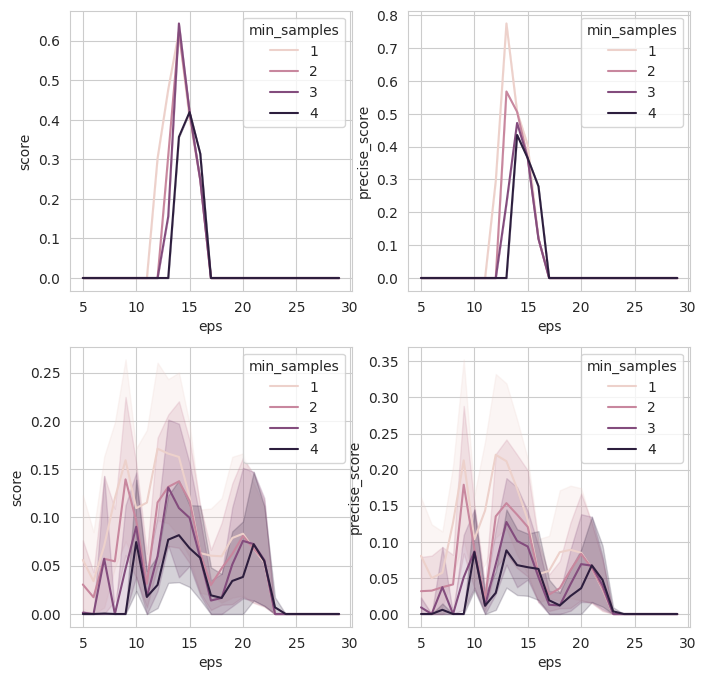

In [179]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


i_dia = 14
i_method = 0
data = df_list[i_method]
data = data[data.i_dia == i_dia]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.lineplot(data, x='eps', y='score', hue='min_samples', ax=ax[0, 0])
sns.lineplot(data, x='eps', y='precise_score', hue='min_samples', ax=ax[0, 1])
data = df_list[i_method]
sns.lineplot(data, x='eps', y='score', hue='min_samples', ax=ax[1, 0])
sns.lineplot(data, x='eps', y='precise_score', hue='min_samples', ax=ax[1, 1])

<Axes: xlabel='n_clusters', ylabel='precise_score'>

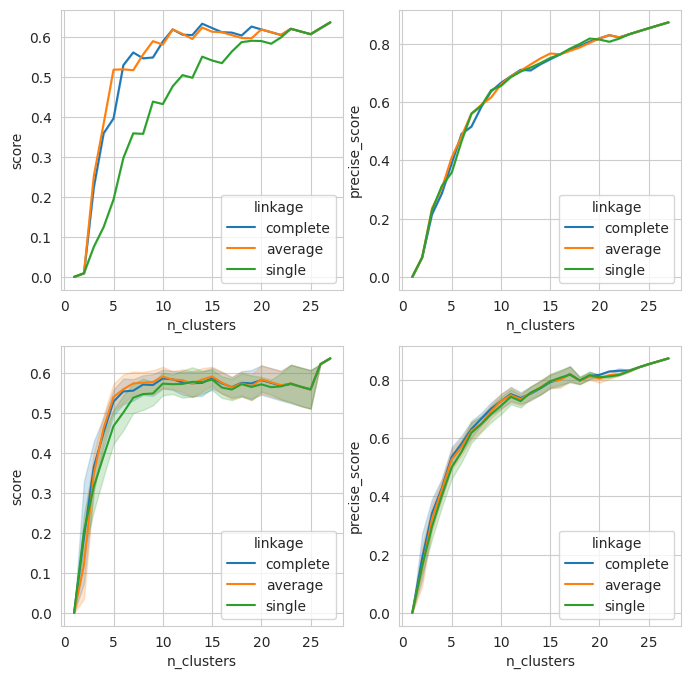

In [184]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


i_dia = 8
i_method = 1
data = df_list[i_method]
data = data[data.i_dia == i_dia]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.lineplot(data, x='n_clusters', y='score', hue='linkage', ax=ax[0, 0])
sns.lineplot(data, x='n_clusters', y='precise_score', hue='linkage', ax=ax[0, 1])
data = df_list[i_method]
sns.lineplot(data, x='n_clusters', y='score', hue='linkage', ax=ax[1, 0])
sns.lineplot(data, x='n_clusters', y='precise_score', hue='linkage', ax=ax[1, 1])

<Axes: xlabel='damping', ylabel='precise_score'>

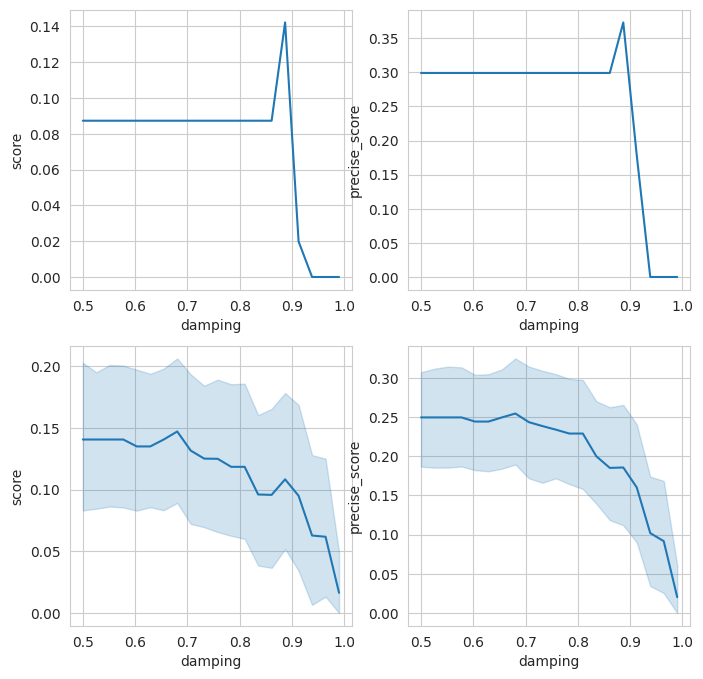

In [183]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


i_dia = 14
i_method = 2
data = df_list[i_method]
data = data[data.i_dia == i_dia]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.lineplot(data, x='damping', y='score', ax=ax[0, 0])
sns.lineplot(data, x='damping', y='precise_score', ax=ax[0, 1])
data = df_list[i_method]
sns.lineplot(data, x='damping', y='score', ax=ax[1, 0])
sns.lineplot(data, x='damping', y='precise_score', ax=ax[1, 1])